<a target="_blank" href="https://colab.research.google.com/github/trainocate-japan/Machine-Learning-and-Deep-Learning-Hands-on/blob/main/answer/6_ディープラーニング/6-4_(演習)PyTorchによるワインの品種分類.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# 6-3_PyTorchによるワインの品種分類
このノートブックでは、PyTorchで分類の予測モデルを作成します。<br>
予測を行うテーマはwineの成分からブドウの品種を予測することです。

## ライブラリのインポート

In [1]:
# データを処理するための基本的なライブラリ
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# scikit-learnから必要なライブラリをインポート
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn import datasets # scikit-learnからデータセットをインポートするためのライブラリ

# PyTorchで使用
import torch
# PyTorchのインポート設定は色々なスタイルがありますが、事前にインポートするとKerasに比べるて非常に多くのインポートを書く必要がある為、
# 今回は使用するたびに全て記載するスタイルをとります。

Google Colaboratory上での出力のデフォルト設定

In [2]:
# pandasのDataframeの出力
pd.set_option('display.max_columns', 500) # 表示列の最大
pd.set_option('display.max_rows', 500) # 表示行の最大
pd.set_option('display.unicode.east_asian_width', True) # 日本語出力時にヘッダのずれを解消
pd.options.display.float_format = '{:,.5f}'.format # 表示桁数の設定

# ノートブックの表示桁数設定。この設定はprint文には作用せず、セルの最後に書いたものを出力する際に適用されます。
%precision 6
# numpy配列の指数表示禁止設定
np.set_printoptions(suppress=True)
# numpy配列の表示桁数設定
np.set_printoptions(precision=6)

## データの準備

In [3]:
# データの読込
wine_dataset = datasets.load_wine()
# データセットのキー項目を確認
print(wine_dataset.keys())

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names'])


In [4]:
# データセットの説明はDESCRに格納されています。
print(wine_dataset['DESCR'])

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

In [5]:
# 目的変数となる変数名と、説明変数となる変数名を確認する
print(wine_dataset['target_names'])
print(wine_dataset['feature_names'])

['class_0' 'class_1' 'class_2']
['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']


In [6]:
# 説明変数となるdataと目的変数となるtargetを確認する
print(type(wine_dataset['data']))
print(wine_dataset['data'].shape)
print(type(wine_dataset['target']))
print(wine_dataset['target'].shape)
# 178行のデータがそれぞれ格納されている

<class 'numpy.ndarray'>
(178, 13)
<class 'numpy.ndarray'>
(178,)


In [7]:
# 説明変数と目的変数をpandasのDataFrameに変換して列名をつけて取り出す
wine_dataset_x = pd.DataFrame(wine_dataset['data'], columns=wine_dataset['feature_names'])
wine_dataset_y = pd.DataFrame(wine_dataset['target'], columns=['Class'])
display(wine_dataset_x.head(3))
display(wine_dataset_y.head(3))

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23000,1.71000,2.43000,15.60000,127.00000,2.80000,3.06000,0.28000,2.29000,5.64000,1.04000,3.92000,"1,065.00000"
1,13.20000,1.78000,2.14000,11.20000,100.00000,2.65000,2.76000,0.26000,1.28000,4.38000,1.05000,3.40000,"1,050.00000"
2,13.16000,2.36000,2.67000,18.60000,101.00000,2.80000,3.24000,0.30000,2.81000,5.68000,1.03000,3.17000,"1,185.00000"


,Class
0,0
1,0
2,0


In [8]:
# データの概要を把握します。
# 説明変数と目的変数のDataFrameを結合します。
wine = pd.concat([wine_dataset_x, wine_dataset_y], axis=1)

print('\n--要約--\n')
display(wine.info())
print('\n--統計情報--\n')
display(wine.describe())


--要約--

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 

None


--統計情報--



,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Class
count,178.00000,178.00000,178.00000,178.00000,178.00000,178.00000,178.00000,178.00000,178.00000,178.00000,178.00000,178.00000,178.00000,178.00000
mean,13.00062,2.33635,2.36652,19.49494,99.74157,2.29511,2.02927,0.36185,1.59090,5.05809,0.95745,2.61169,746.89326,0.93820
std,0.81183,1.11715,0.27434,3.33956,14.28248,0.62585,0.99886,0.12445,0.57236,2.31829,0.22857,0.70999,314.90747,0.77503
min,11.03000,0.74000,1.36000,10.60000,70.00000,0.98000,0.34000,0.13000,0.41000,1.28000,0.48000,1.27000,278.00000,0.00000
25%,12.36250,1.60250,2.21000,17.20000,88.00000,1.74250,1.20500,0.27000,1.25000,3.22000,0.78250,1.93750,500.50000,0.00000
50%,13.05000,1.86500,2.36000,19.50000,98.00000,2.35500,2.13500,0.34000,1.55500,4.69000,0.96500,2.78000,673.50000,1.00000
75%,13.67750,3.08250,2.55750,21.50000,107.00000,2.80000,2.87500,0.43750,1.95000,6.20000,1.12000,3.17000,985.00000,2.00000
max,14.83000,5.80000,3.23000,30.00000,162.00000,3.88000,5.08000,0.66000,3.58000,13.00000,1.71000,4.00000,"1,680.00000",2.00000


In [9]:
# 目的変数を確認してみる
print(wine_dataset['target'])
# 0,1,2は先ほど表示したfeature_namesに対応している。(今回は品種名までは書かれていない)
# 0:class_0、1:class_1、2:class_2
# ★PyTorchの多値分類では正解データを0,1,2,・・・というラベルの表現のまま渡すので、one-hot表現は不要

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [10]:
# 訓練データと検証データに分割（80%を訓練用に使用）
train_x, test_x, train_y, test_y = train_test_split(wine_dataset_x, wine_dataset['target'], train_size=0.8, test_size=0.2, random_state=0, stratify=wine_dataset['target']) 
# さらに訓練データを検証データに分割（訓練データの20%を検証用に使用）
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, train_size=0.8, test_size=0.2, random_state=0) 

In [11]:
# 標準化を行う
# 標準化はscikit-learnに用意されている
scaler_x = StandardScaler()
scaler_x.fit(train_x)
train_x_scaled = scaler_x.transform(train_x)
val_x_scaled = scaler_x.transform(val_x)
test_x_scaled = scaler_x.transform(test_x)

print(type(train_x_scaled))
print(train_x_scaled[:2])
print(type(val_x_scaled))
print(val_x_scaled[:2])
print(type(test_x_scaled))
print(test_x_scaled[:2])
# scikit-learnのStandardScalerを使用するとnumpy配列になるので、説明変数はpandasのデータフレームからnumpyへの変換は不要
# 目的変数もデータセットから直接取得している場合にはnumpy配列なので変換は不要

<class 'numpy.ndarray'>
[[ 0.46426   1.337911 -0.959912 -0.263148 -0.654115  0.245045  0.604217
  -0.767896 -0.171102 -0.317867 -0.222283  0.519187  0.811788]
 [ 0.670801  0.212472  1.102394  1.420004  0.412993 -1.192156 -1.18333
   0.237188 -0.065545  1.596764 -0.968013 -1.197928 -0.045268]]
<class 'numpy.ndarray'>
[[ 0.646502 -0.564616 -0.272477 -1.030901  1.266679  1.362867  1.196828
  -0.181597  1.341884  0.490824 -0.046817  1.06294   0.090057]
 [ 0.719399  2.329369 -0.127753  0.0912   -0.511834 -0.473555 -1.22219
   0.907244 -0.980374 -0.265412 -0.222283 -0.840196 -0.64671 ]]
<class 'numpy.ndarray'>
[[-1.042274 -0.79685   0.523501 -0.20409   0.341852 -0.649213 -0.299271
   0.73973  -0.962781 -0.899251  2.146507 -0.582629 -1.233117]
 [ 0.306317 -0.627141  1.645106 -1.237603  0.768695  0.484578  0.604217
  -0.181597 -0.382217 -0.177986  0.567314  0.204382  0.34567 ]]


#### データをtorchtensorに変換する

In [12]:
# numpy配列をテンソルに変換
# ★多値分類では回帰とはデータの準備が異なる部分があります。 
# 目的変数はone-hot表現にはせず、N行1列の形にもせず、1次配列の形で用意します。
train_x_scaled = torch.Tensor(train_x_scaled).float()
train_y = torch.Tensor(train_y).long()
val_x_scaled = torch.Tensor(val_x_scaled).float()
val_y = torch.Tensor(val_y).long()
test_x_scaled = torch.Tensor(test_x_scaled).float()
test_y = torch.Tensor(test_y).long()
## データをテンソルデータセットインスタンスにする
train_dataset = torch.utils.data.TensorDataset(train_x_scaled, train_y)
val_dataset = torch.utils.data.TensorDataset(val_x_scaled, val_y)
test_dataset = torch.utils.data.TensorDataset(test_x_scaled, test_y)

## モデルの定義

In [13]:
# 乱数シードの固定
torch.manual_seed(0)

# ニューラルネットワークを定義
class Net(torch.nn.Module):

  # 必要な層や活性化関数を定義する
  def __init__(self):
    super(Net, self).__init__()
    self.l1 = torch.nn.Linear(train_x.shape[1], 128)     # 中間層1
    self.a1 = torch.nn.ReLU()  # 活性化関数1
    self.l2 = torch.nn.Linear(128, 128)   # 中間層2
    self.a2 = torch.nn.ReLU()  # 活性化関数2
    self.l3 = torch.nn.Linear(128, 3)     # 出力層

  # 順伝搬を定義。引数のxは、説明変数。
  # 順番に関数を実行し、その結果を次の関数に渡していく
  def forward(self, x):
    x = self.l1(x)
    x = self.a1(x)
    x = self.l2(x)
    x = self.a2(x)
    x = self.l3(x)
    return x

## 学習

In [14]:
num_epochs = 700

# データローダーの用意
# PyTorchではデータローダーに格納されたデータセットをバッチサイズで区切って、学習のたびに取り出します。
# shuffleをTrueに設定することで、データをシャッフルして取り出します(★batch_sizeをデータ量に合わせて32に設定)
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# モデルをインスタンス化
net = Net()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001) # 最適化手法の用意
criterion = torch.nn.CrossEntropyLoss() # ★誤差関数の用意(多値分類なので、交差エントロピー誤差を使う)

## 学習時に経過情報を保存する空リストを作成
train_loss_list = []      # 学習データの誤差関数用リスト
val_loss_list = []        # 検証データの誤差関数用リスト

# エポック分の繰り返し
for epoch in range(num_epochs):
    
    #学習の進行状況を表示
    print('--------')
    print("Epoch: {}/{}".format(epoch + 1, num_epochs))

    # 損失の初期化
    train_loss = 0        # 学習データの誤差関数
    val_loss = 0          # 検証データの誤差関数
    
    #=====学習パート=======
    # 学習モードに設定
    # PyTorchでは学習時と評価時でモードを切り替える
    net.train()

    #ミニバッチごとにデータをロードして学習
    for x, y in train_dataloader:
        preds = net(x)                            # 順伝搬で予測を実行
        loss = criterion(preds, y)                # 誤差関数を計算
        optimizer.zero_grad()                     # 勾配を初期化
        loss.backward()                           # 勾配を計算
        optimizer.step()                          # パラメータ更新
        train_loss += loss.data.numpy().tolist()  # ミニバッチごとの損失を格納   
    #ミニバッチの平均の損失を計算
    batch_train_loss = train_loss / len(train_dataloader)
    
    #=====評価パート(検証データ)=======
    # 評価モードに設定
    net.eval()
    # 評価時は勾配計算は不要なので、勾配計算を無効にして負荷を下げる
    with torch.no_grad():
        for x, y in val_dataloader:
            preds = net(x)                        # 順伝搬で予測を実行
            loss = criterion(preds, y)            # 誤差関数を計算
            val_loss += loss.item()               # ミニバッチごとの損失を格納    
    #ミニバッチの平均の損失を計算
    batch_val_loss = val_loss / len(val_dataloader)
    
    #エポックごとに損失を表示
    print("Train_Loss: {:.4f}".format(batch_train_loss))
    print("val_loss: {:.4f}".format(batch_val_loss))
    #損失をリスト化して保存
    train_loss_list.append(batch_train_loss)
    val_loss_list.append(batch_val_loss)

--------
Epoch: 1/700
Train_Loss: 1.0410
val_loss: 0.9546
--------
Epoch: 2/700
Train_Loss: 0.8869
val_loss: 0.8241
--------
Epoch: 3/700
Train_Loss: 0.7407
val_loss: 0.6926
--------
Epoch: 4/700
Train_Loss: 0.5889
val_loss: 0.5609
--------
Epoch: 5/700
Train_Loss: 0.4645
val_loss: 0.4381
--------
Epoch: 6/700
Train_Loss: 0.3426
val_loss: 0.3328
--------
Epoch: 7/700
Train_Loss: 0.2379
val_loss: 0.2521
--------
Epoch: 8/700
Train_Loss: 0.1794
val_loss: 0.1941
--------
Epoch: 9/700
Train_Loss: 0.1239
val_loss: 0.1556
--------
Epoch: 10/700
Train_Loss: 0.0949
val_loss: 0.1306
--------
Epoch: 11/700
Train_Loss: 0.0697
val_loss: 0.1164
--------
Epoch: 12/700
Train_Loss: 0.0543
val_loss: 0.1057
--------
Epoch: 13/700
Train_Loss: 0.0454
val_loss: 0.0984
--------
Epoch: 14/700
Train_Loss: 0.0336
val_loss: 0.0935
--------
Epoch: 15/700
Train_Loss: 0.0293
val_loss: 0.0911
--------
Epoch: 16/700
Train_Loss: 0.0233
val_loss: 0.0855
--------
Epoch: 17/700
Train_Loss: 0.0219
val_loss: 0.0814
------

## 評価

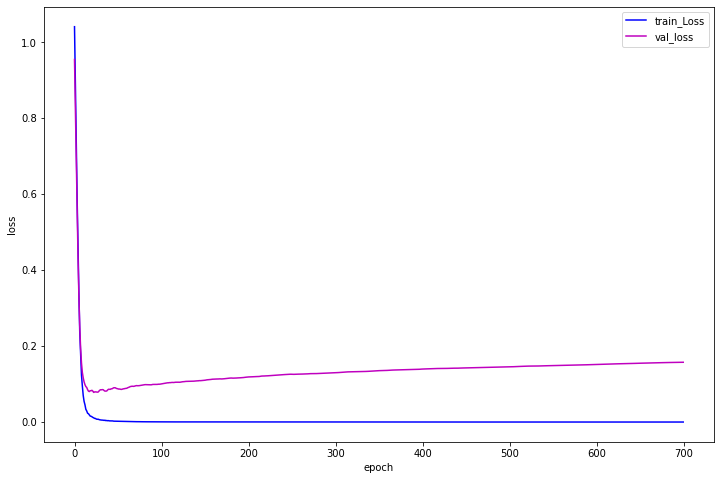

テストデータに対する予測精度：1.0



In [15]:
# この後精度改善のために何度か確認するので、関数化しておきます
def myevaluete():

  # 誤差関数の可視化
  fig = plt.figure() # グラフの描画領域全体のオブジェクトを取得
  fig.set_figheight(8) # 縦の幅を指定
  fig.set_figwidth(12) # 横の幅を指定
  plt.plot(train_loss_list, color='b', label='train_Loss')
  plt.plot( val_loss_list, color='m', label='val_loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()

  net.eval() # モデルを評価モードにする

  # テストデータ用のデータローダを用意
  test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

  y_pred = None
  with torch.no_grad():
      # ミニバッチで取り出しながら、最初のバッチはy_predに設定し、
      # 2回目以降はそこへnumpy配列で接続していく
      for inputs, labels in test_dataloader:
          outputs = net(inputs)
          if y_pred is None:
              y_pred = outputs.data.numpy()
          else:
              y_pred = np.concatenate([y_pred, outputs.data.numpy()])

  # np.argmaxで最も確率が高い値を0,1,2に変換する
  accuracy = accuracy_score(test_y, np.argmax(y_pred, axis=1))
  print('テストデータに対する予測精度：{}\n'.format(accuracy))

myevaluete()

# ニューラルネットワークモデルを改良する

In [16]:
# Early-Stopping機能を実装したクラス
class EarlyStopping:

  def __init__(self, patience=0):
    self._step = 0              # lossが改善しなかった連続回数をカウントする。先頭の_は内部的であることを表わしています
    self._loss = float('inf')   # そこまでで最も改善が見られたlossの値を格納する
    self.patience = patience    # 引数で指定する、何回改善されなかったら早期終了するかの回数

  def __call__(self, loss):
    if self._loss < loss:
      self._step += 1   # lossが改善しなければ_stepを1増やす
      if self._step >= self.patience:    # patienceの回数改善しなかったら早期終了する
        print('early stopping')
        return True
    else:               # lossが改善した場合は_stepを0にして_lossを更新する
      self._step = 0
      self._loss = loss
    return False

In [17]:
# 乱数シードの固定
torch.manual_seed(0)

# ニューラルネットワークを定義
class Net(torch.nn.Module):

  # 必要な層や活性化関数を定義する
  def __init__(self):
    super(Net, self).__init__()
    self.l1 = torch.nn.Linear(train_x.shape[1], 128)     # 中間層1
    self.a1 = torch.nn.ReLU()             # 活性化関数1
    self.d1 = torch.nn.Dropout(0.2)       # ★ドロップアウト層1★
    self.l2 = torch.nn.Linear(128, 128)   # 中間層2
    self.a2 = torch.nn.ReLU()             # 活性化関数2
    self.d2 = torch.nn.Dropout(0.2)       # ★ドロップアウト層2★
    self.l3 = torch.nn.Linear(128, 3)     # 出力層

  # 順伝搬を定義。引数のxは、説明変数。
  # 順番に関数を実行し、その結果を次の関数に渡していく
  def forward(self, x):
    x = self.l1(x)
    x = self.a1(x)
    x = self.d1(x) # ★ドロップアウト層1★
    x = self.l2(x)
    x = self.a2(x)
    x = self.d2(x) # ★ドロップアウト層2★
    x = self.l3(x)
    return x

In [18]:
num_epochs = 700

# データローダーの用意
# PyTorchではデータローダーに格納されたデータセットをバッチサイズで区切って、学習のたびに取り出します。
# shuffleをTrueに設定することで、データをシャッフルして取り出します
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ★早期終了のインスタンスを準備★
es = EarlyStopping(patience=10)

# モデルをインスタンス化
net = Net()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01) # 最適化手法の用意
criterion = torch.nn.CrossEntropyLoss() # ★誤差関数の用意(多値分類なので、交差エントロピー誤差を使う)

## 学習時に経過情報を保存する空リストを作成
train_loss_list = []      # 学習データの誤差関数用リスト
val_loss_list = []        # 検証データの誤差関数用リスト

# エポック分の繰り返し
for epoch in range(num_epochs):
    
    #学習の進行状況を表示
    print('--------')
    print("Epoch: {}/{}".format(epoch + 1, num_epochs))

    # 損失の初期化
    train_loss = 0        # 学習データの誤差関数
    val_loss = 0          # 検証データの誤差関数
    
    #=====学習パート=======
    # 学習モードに設定
    # PyTorchでは学習時と評価時でモードを切り替える
    net.train()

    #ミニバッチごとにデータをロードして学習
    for x, y in train_dataloader:
        preds = net(x)                            # 順伝搬で予測を実行
        loss = criterion(preds, y)                # 誤差関数を計算
        optimizer.zero_grad()                     # 勾配を初期化
        loss.backward()                           # 勾配を計算
        optimizer.step()                          # パラメータ更新
        train_loss += loss.data.numpy().tolist()  # ミニバッチごとの損失を格納   
    #ミニバッチの平均の損失を計算
    batch_train_loss = train_loss / len(train_dataloader)
    
    #=====評価パート(検証データ)=======
    # 評価モードに設定
    net.eval()
    # 評価時は勾配計算は不要なので、勾配計算を無効にして負荷を下げる
    with torch.no_grad():
        for x, y in val_dataloader:
            preds = net(x)                        # 順伝搬で予測を実行
            loss = criterion(preds, y)            # 誤差関数を計算
            val_loss += loss.item()               # ミニバッチごとの損失を格納    
    #ミニバッチの平均の損失を計算
    batch_val_loss = val_loss / len(val_dataloader)
    
    #エポックごとに損失を表示
    print("Train_Loss: {:.4f}".format(batch_train_loss))
    print("val_loss: {:.4f}".format(batch_val_loss))
    #損失をリスト化して保存
    train_loss_list.append(batch_train_loss)
    val_loss_list.append(batch_val_loss)

    # ★早期終了判定★
    if es(batch_val_loss):
      break

--------
Epoch: 1/700
Train_Loss: 1.0931
val_loss: 1.0833
--------
Epoch: 2/700
Train_Loss: 1.0699
val_loss: 1.0674
--------
Epoch: 3/700
Train_Loss: 1.0595
val_loss: 1.0520
--------
Epoch: 4/700
Train_Loss: 1.0496
val_loss: 1.0373
--------
Epoch: 5/700
Train_Loss: 1.0293
val_loss: 1.0216
--------
Epoch: 6/700
Train_Loss: 1.0099
val_loss: 1.0071
--------
Epoch: 7/700
Train_Loss: 1.0104
val_loss: 0.9925
--------
Epoch: 8/700
Train_Loss: 0.9938
val_loss: 0.9788
--------
Epoch: 9/700
Train_Loss: 0.9681
val_loss: 0.9648
--------
Epoch: 10/700
Train_Loss: 0.9542
val_loss: 0.9514
--------
Epoch: 11/700
Train_Loss: 0.9302
val_loss: 0.9363
--------
Epoch: 12/700
Train_Loss: 0.9310
val_loss: 0.9218
--------
Epoch: 13/700
Train_Loss: 0.9076
val_loss: 0.9067
--------
Epoch: 14/700
Train_Loss: 0.9028
val_loss: 0.8924
--------
Epoch: 15/700
Train_Loss: 0.8752
val_loss: 0.8775
--------
Epoch: 16/700
Train_Loss: 0.8640
val_loss: 0.8633
--------
Epoch: 17/700
Train_Loss: 0.8424
val_loss: 0.8492
------

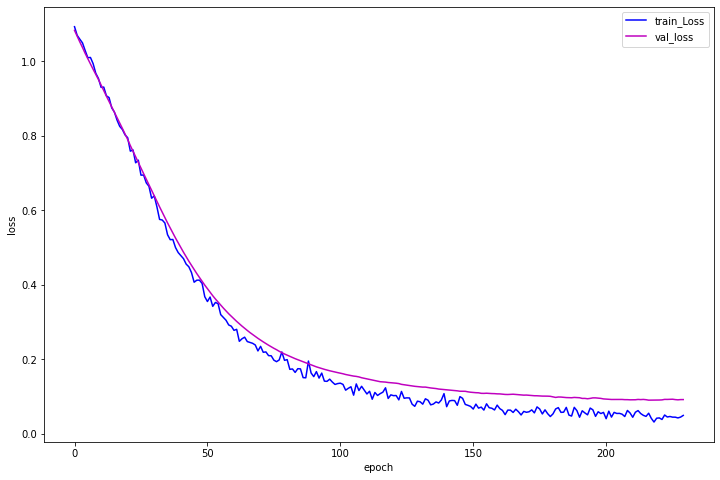

テストデータに対する予測精度：1.0



In [19]:
myevaluete()

※ ニューラルネットワークの構成によっては、結果が97.2%もしくは100%になるかもしれません。これはテストデータを切り出す際に全体の20%で指定をすると36件のデータがテストデータとなり、そのうちの35件を正しく予測できると97.2%になるため、35件あてられたか、36件あてられたかの違いです。<br>
分類問題の精度は正解率なので、0か1のやや極端な値です。ギリギリ正解だったのか、余裕で正解だったのかは考慮されていません。そういった関係から直感的にはわかりにくいものの、誤差関数のほうが評価指標として優先される場合もあります。